<a href="https://colab.research.google.com/github/francobarrionuevoenv21/PaddyFieldStaFe_Segm_UNETs_public/blob/main/BestUNET_predictV1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

### About the Project

The project consisted in training a Convolutional Neural Network to detect active/in-production paddy fields in Santa Fe province, Argentina. This area was originally characterized by wetlands, but in recent decades these natural ecosystems have been converted into paddy fields.

The approach will involve training a basic [U-Net neural network](https://www.geeksforgeeks.org/machine-learning/u-net-architecture-explained/) along with two variations. These variations will use different backbones and pretrained weights.

### Notebook Description

In this notebook, the best trained model is used to segmentate by predicting and identify paddy fields in the study area. The model with the best performance of the three variations was the UNET + Backbone SEResnet 34 with Imagenet pretrained weights. The obtained metrics were

- IoU (Threshold: 0.35): 0.964
- Precision: 0.974
- Recall: 0.971

# Code Development

**NOTE**: The following code performs the processing of individual composite scenes. For each L8 image obtained the same steps are applied

In [ ]:
## INSTALL DEPENDENCIES AND IMPORT LIBRARIES

# Standard
import os
from google.colab import files
import json

# Data & Viz
import geopandas as gpd
from shapely.geometry import shape
!pip install rasterio
import rasterio
from rasterio.merge import merge
from rasterio.features import shapes # https://rasterio.readthedocs.io/en/latest/api/rasterio.features.html#rasterio.features.shapes
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread
from skimage.transform import resize

# Model Tensorflow and Keras
import tensorflow as tf
import keras
from keras.models import Model
from keras.layers import Conv2D, Input

# Model Segmenetation framework
!pip install segmentation-models -q
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm
from segmentation_models import Unet
from segmentation_models.losses import bce_jaccard_loss, binary_focal_dice_loss
from segmentation_models.metrics import iou_score
from segmentation_models import get_preprocessing


In [ ]:
# INSTALL PYSATPROC FOR IMAGES CHIPPING AND MASKS GENERATION
!pip install pysatproc

In [ ]:
# IMPORT L8 SCENES AND BEST MODEL FILES

In [ ]:
# UNZIP FOLDERS WITH THE L8 SCENES BY YEAR AND THE TRAINED MODEL FILES

# Set file path and create the output foleder

##  L8 scenes
zip_file_path_01 = '...'
destination_folder_01 = '/content/l8_scenes'
os.makedirs(destination_folder_01, exist_ok=True) # Create the destination folder if it doesn't exist
## Model trained files
zip_file_path_02 = '...'
destination_folder_02 = '/content/model_files'
os.makedirs(destination_folder_02, exist_ok=True) # Create the destination folder if it doesn't exist

# Unzip the compressed files in the destionation folder
!unzip -q {zip_file_path_01} -d {destination_folder_01}
!unzip -q {zip_file_path_02} -d {destination_folder_02}

In [ ]:
## SET FILE PATH AND CREATE OUTPUT FOLDER FOR IMAGES + NDVI
destination_folder_03 = '/content/l8_scenes_wNDVI'
os.makedirs(destination_folder_03, exist_ok=True)

##Scene Selection

**NOTE**: To select the scene corresponding to the year Y, it has to be set a Previous Year (prev_year) as Y-1, Analisys Year (anls_year) as Y in string format

In [ ]:
prev_year = "2015"
anls_year = "2016"

## Data Processing and Chips Generation

###Raster processing and NDWI computing

In [ ]:
# READ L8 SCENE AS RASTER AND COMPUTE NDWI

# Open the scene
tif_path = f'/content/l8_scenes/L8_comp_clipped_{prev_year[-2:]}to{anls_year[-2:]}_int16.tif'
tif = rasterio.open(tif_path)

# Compute NDVI additional band
infile = tif_path # RGB + NIR raster path
outfile = f"{destination_folder_03}/{tif_path[19:-10]}_with_NDVI.tif"

## Read input file
with rasterio.open(infile) as src:
    profile = src.profile.copy()
    red  = src.read(3).astype("float32")  # Landsat 8 RED = band
    nir  = src.read(4).astype("float32")  # Landsat 8 NIR = band
    bands = src.read()                    # read all original bands

## Calculate NDVI
ndvi = (nir - red) / (nir + red + 1e-10)  # add epsilon to avoid /0

## Update profile
profile.update(
    count = bands.shape[0] + 1,   # add NDVI as new band
    dtype = "float32"
)

## Write the output with the NDVI band
with rasterio.open(outfile, "w", **profile) as dst:
    # write original bands
    for i in range(bands.shape[0]):
        dst.write(bands[i], i + 1)

    ## write NDVI as last band
    dst.write(ndvi.astype("float32"), bands.shape[0] + 1)

# OPEN THE CREATED RASTER FOR LATER VISUALIZATION
tif_wNDVI = rasterio.open(outfile)

print("L8 scene with NDVI computed")

#### Chips and Masks Generation with *pysatproc*

**NOTE**: Chips created are 128x128 (size 128) pixels with 50% overlapping (step-size 64). No masks are created in this step.

In [ ]:
# CREATE CHIPS OF THE SCENE (w/ NDVI)

# Define a folder to save the chips
fpath_foldChips = f'/content/chips_{anls_year}_128px'

## Define the command in str format
command_str = f"""satproc_extract_chips \
    {outfile} \
    -o {fpath_foldChips} \
    --size 128 \
    --step-size 64 \
    --rescale \
    --rescale-mode percentiles \
    --upper-cut 98 --lower-cut 2
"""

!{command_str}

'''
--rescale-mode percentiles
Normalize reflectance values based on percentile stretching of pixel intensities.

--upper-cut and --lower-cut
Used only when --rescale-mode percentiles is selected.

  --lower-cut 2  → map the 2nd percentile to value = 0
  --upper-cut 98 → map the 98th percentile to value = 1
'''

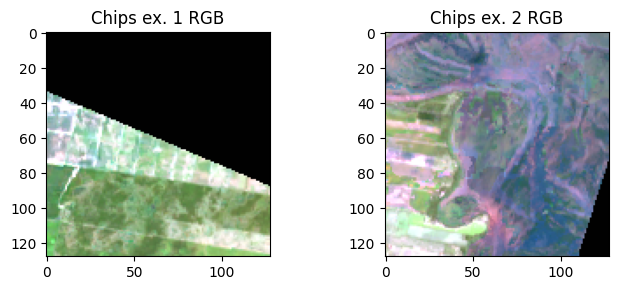

In [ ]:
# VISUALIZE CHIPS EXAMPLES

## Example 1
path_ex01 = 'L8_comp_clipped_15to16_with_NDVI_0_30.tif'
path_ex01_img = '/content/chips_2016_128px/images/' + path_ex01

## Example 2
path_ex02 = 'L8_comp_clipped_15to16_with_NDVI_15_36.tif'
path_ex02_img = '/content/chips_2016_128px/images/' + path_ex02

## VISUALIZE EXAMPLES
fig, axs = plt.subplots(1, 2, figsize=(7, 3))

## Example 01
axs[0].imshow(rasterio.open(path_ex01_img).read().transpose(1, 2, 0)[:,:,:3])
axs[0].set_title('Chips ex. 1 RGB')

## Example 02
axs[1].imshow(rasterio.open(path_ex02_img).read().transpose(1, 2, 0)[:,:,:3])
axs[1].set_title('Chips ex. 2 RGB')

plt.tight_layout()

plt.show()

## Predict with the trained model

The model used for predicting and detecting paddy fields in the study area is the UNET + Backbone SEResnet 34 with Imagenet pretrained weights. This model was the one with the best performance according to the following metrics
- IoU (Threshold: 0.35): 0.964
- Precision: 0.974
- Recall: 0.971

### Data Loading

In [ ]:
# GET CHIPS OF IMAGES PATH

images = []
image_path = f'/content/chips_{anls_year}_128px/images/'

## Sort directions
image_names = sorted(next(os.walk(image_path))[-1])

In [ ]:
# CREATE FUNCTION TO LOAD IMAGES

def load_images(image_paths, img_size=(128, 128, 5)):
    '''
    This functions takes images path to load them as numpy arrays and normalizes its values to 0-1
    '''
    images = [resize(imread(path_img+path), img_size, preserve_range=True) for path in image_paths]

    images = np.array(images, dtype=np.float32)

    ## Values normalization 0-1
    images /= 255.0

    return images

In [ ]:
# LOAD AND SAVE IMAGES

# Get images path
path_img = image_path

# Load and save images using the function
images = load_images(image_names)

# Save images in variables standard for ML
X = images

# Print X data shape
print(X.shape)

### Model implementation and prediction

**NOTE**: U-Nen + SEResNet architecture implementation is based in the [Segmentation Models framework](https://github.com/qubvel/segmentation_models/tree/master)

In [ ]:
# DEFINE UNET ALTERNATIVE COMPONENTS

# Define model name
model_name_str03 = "UNetBackboneSEResNet34v3"

# Define backbone
BACKBONE_02 = 'seresnet34'

# Define base model
## The model is initialized using imagenet pretrained weights
base_model_sn34 = Unet(backbone_name=BACKBONE_02, encoder_weights='imagenet')

# Get number of channels
N = 5

# Add extra convolutional layer to map N channels to 3
inp = Input(shape=(None, None, N))
l1 = Conv2D(3, (1, 1))(inp) # map N channels data to 3 channels
out = base_model_sn34(l1)

# Define model
unet_sn34 = Model(inp, out, name=base_model_sn34.name)

# Compile the model
unet_sn34.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss=binary_focal_dice_loss,
                  metrics=[iou_score])

# Preprocess training data
preprocess_input = get_preprocessing(BACKBONE_02)
X[..., :3] = preprocess_input(X[..., :3])

# Load weights
unet_sn34.load_weights("/content/model_files/UNet-03.weights.h5")

86315168/86315168 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 410 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


### Predict paddy fields on L8 scene chips

In [ ]:
# PREDICT USING THE BEST MODEL
model_sn34_pred = unet_sn34.predict(X)

100/100 ━━━━━━━━━━━━━━━━━━━━ 292s 3s/step


In [ ]:
# APPLY THRESHOLD TO THE PREDICTIONS

# Get json file with model metrics
with open("/content/model_files/UNetBackboneSEResNet34v3_info.json", "r") as f:
    model_metrics = json.load(f)

# Apply the threshold to the predictions
model_sn34_pred_thrs = model_sn34_pred.copy()
model_sn34_pred_thrs[model_sn34_pred_thrs>=model_metrics["best_threshold"]] = 1
model_sn34_pred_thrs[model_sn34_pred_thrs<model_metrics["best_threshold"]] = 0

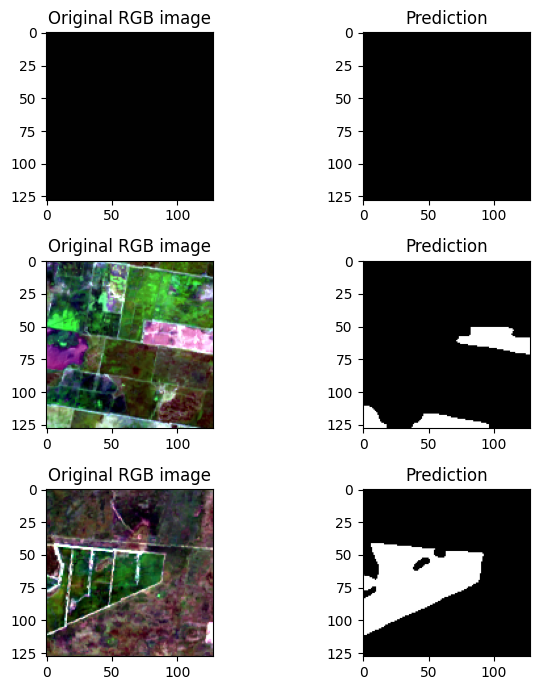

In [ ]:
# PLOT RANDOM EXAMPLES
fig, axes = plt.subplots(3, 2, figsize=(7, 7))

for i in range(3):

  id = np.random.randint(len(X))
  axes[i, 0].imshow(X[id][:,:,:3])
  axes[i, 0].set_title("Original RGB image")
  axes[i, 1].imshow(model_sn34_pred_thrs[id].reshape(128,128), cmap='Grays_r')
  axes[i, 1].set_title("Prediction")

plt.tight_layout()
plt.show()

### Create a mosaic with predictions and vectorizate them

In [ ]:
# CREATE FOLDER FOR PREDICTIONS MOSAIC
destination_folder_04 = '/content/mosaics_tif'
os.makedirs(destination_folder_04, exist_ok=True)

In [ ]:
# DEFINE FOLDERS AND OUTPUT NAMES

# Get chips folder for output georreferencing
chips_dir = f"/content/chips_{anls_year}_128px/images"

# Define georreferenced masks output
out_geotiffs = f"/content/masks_georef{anls_year}/"
os.makedirs(out_geotiffs, exist_ok=True)

# Get and save predictions (masks) in a list for posterior processing
predictions = {}

for idx, p in enumerate(image_names):
  predictions[p] = model_sn34_pred_thrs[idx, :, :, :]

In [ ]:
# GEORREFERENCE MASKS (PREDICTIONS)

for fname, mask in predictions.items():

    chip_path = os.path.join(chips_dir, fname)

    # Open chip to copy spatial metadata
    with rasterio.open(chip_path) as src:
        profile = src.profile
        transform = src.transform
        crs = src.crs

    # Ensure mask is 2D, not (H, W, 1)
    if mask.ndim == 3:
        mask = mask[:, :, 0]

    mask = mask.astype("uint16")

    # Set single band output
    profile.update(
        dtype="uint16",
        count=1,
        compress="lzw"
    )

    out_path = os.path.join(out_geotiffs, fname.replace(".tif", "_mask.tif"))
    with rasterio.open(out_path, "w", **profile) as dst:
        dst.write(mask, 1)

print("Georeferenced masks saved to:", out_geotiffs)

Georeferenced masks saved to: /content/masks_georef2016/


In [ ]:
# CREATE A MOSAIC WITH PREDICTIONS
# Method applied for mosaicking: max value

tifs = [os.path.join(out_geotiffs, f)
        for f in os.listdir(out_geotiffs) if f.endswith(".tif")]

srcs = [rasterio.open(t) for t in tifs]

# Mosaic is (1, H, W)
mosaic, out_transform = merge(srcs, method = "max")

# Sase profile
out_profile = srcs[0].profile
out_profile.update(
    height=mosaic.shape[1],
    width=mosaic.shape[2],
    transform=out_transform
)

# Save mosaic
mosaic_path = destination_folder_04 + f"/predicts_{anls_year}.tif"
with rasterio.open(mosaic_path, "w", **out_profile) as dst:
    dst.write(mosaic)

print("Mosaic created:", mosaic_path)

Mosaic created: /content/mosaics_tif/predicts_2016.tif


In [ ]:
# VECTORIZE THE PREDICTIONS

# Open and read the mosaic with rasterio
mosaic_pred = rasterio.open(mosaic_path).read(1)

# Vectorize the predictions
with rasterio.open(mosaic_path) as src:
      image = src.read(1)  # Read the first band
      transform = src.transform
      # Extract shapes (polygons) from the raster
      results = (
          {'properties': {'value': v}, 'geometry': s}
          for i, (s, v) in enumerate(shapes(image, connectivity = 8, transform=transform)) # 8 connectivity defined
      )
      # Convert to GeoDataFrame
      geometries = list(results)
      gdf = gpd.GeoDataFrame.from_features(geometries, crs=src.crs)

# Select only vector assigned as paddy fields (value = 1)
gdf_sel = gdf[gdf['value']==1]

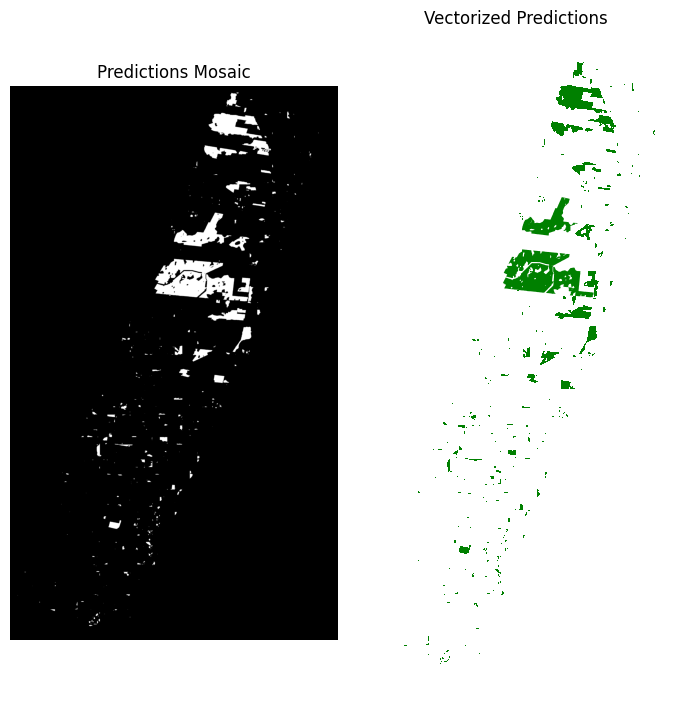

In [ ]:
# VISUALIZE MOSAIC AND ITS VECTORIZATION

fig, axes = plt.subplots(1, 2, figsize=(7, 7))

axes[0].imshow(mosaic_pred, cmap='gray')
axes[0].set_title("Predictions Mosaic")
axes[0].axis('off')
gdf_sel.plot(ax=axes[1], color = "green", )
axes[1].set_title("Vectorized Predictions")
axes[1].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# SAVE AND DOWNLOAD THE VECTORIZED PREDICTIONS

# Create a folder for vectors
destination_folder_05 = '/content/vectors_predicts'
os.makedirs(destination_folder_05, exist_ok=True)

# Save the vector
output_geojson_path = destination_folder_05 + f"/vector_predict_{anls_year}.geojson"
gdf_sel.to_file(output_geojson_path, driver="GeoJSON")
print(f"GeoJSON saved to: {output_geojson_path}")

# Download the vector
files.download(output_geojson_path)

GeoJSON saved to: /content/vectors_predicts/vector_predict_2016.geojson


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>